In [ ]:
# maybe use ward instead of borough?

In [ ]:
# http://overpass-turbo.eu/
# https://download.geofabrik.de/europe/hungary.html
# https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london
# EPSG:4326

# mappek

# 1 - 100
# minden map 0-1
# 0.5 bunozesben
# 0.5 iskolaban akkor
# 25
# sok lehetoseg -> kivalasztja miket szertne (es rangsorolhatja is) es akkor mapek es ertek

#Zaj
#criminals!!!
#Smog
#School bontas
#Shopping
#Green
#Public trabsport
# bicikli
# auto
#church
# zona


## get london map

In [29]:
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster
import geopandas as gpd
import json
import matplotlib.pyplot as plt
import numpy as np
import osmium
import pandas as pd
import requests
from shapely.geometry import Point
import shapely.wkb


In [2]:
LONDON_LOC = [51.5072,-0.1276]
LONDON_ZOOM = 10

In [15]:
city_border_gdf.head()

OA11CD       25053
LSOA11CD     25053
MSOA11CD     25053
WD11CD_BF    25053
WD11NM_BF    25053
LAD11CD      25053
LAD11NM      25053
RGN11CD      25053
RGN11NM      25053
LSOA11NM     25053
MSOA11NM     25053
USUALRES     25053
HHOLDRES     25053
COMESTRES    25053
POPDEN       25053
HHOLDS       25053
AVHHOLDSZ    25053
geometry     25053
dtype: int64

In [61]:
## boroughs
boroughs_border_gdf = gpd.read_file("statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp")
boroughs_border_gdf = boroughs_border_gdf.to_crs("EPSG:4326")


In [4]:
## boroughs map
m_boroughs = folium.Map(location=LONDON_LOC, zoom_start=LONDON_ZOOM, tiles="CartoDB positron")

for _, r in boroughs_border_gdf.iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo = gpd.GeoSeries(r["geometry"])
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {"fillColor": "orange"})
    folium.Popup(r["NAME"]).add_to(geo_j)
    geo_j.add_to(m_boroughs)
m_boroughs

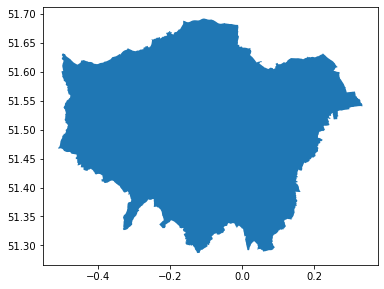

In [44]:
# london border
polygon = boroughs_border_gdf.geometry.unary_union
london_border_gdf = gpd.GeoDataFrame(geometry=[polygon], crs=boroughs_border_gdf.crs)
london_border_gdf.plot(figsize=(6, 6))
london_poly = london_border_gdf["geometry"][0]
plt.show()

In [5]:
## schools
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json];
area["ISO3166-1"="GB"][admin_level=2];
(node["amenity"="school"](area);
 way["amenity"="school"](area);
 rel["amenity"="school"](area);
);
out center;
"""
response = requests.get(overpass_url, 
                        params={'data': overpass_query})
data = response.json()

In [32]:
# Collect coords into list
lts = []
lns = []
nms = [] 
for element in data['elements']:
    if element['type'] == 'node':
        lns.append(element['lon'])
        lts.append(element['lat'])
        try:
            nms.append(element['tags']['name'])
        except:
            nms.append("Unknown")
        
df_school = pd.DataFrame(
    {'Lat': lts,
     'Long': lns,
     'Name': nms
    })

geometry = [Point(xy) for xy in zip(df_school.Long, df_school.Lat)]
df_school = df_school.drop(['Long', 'Lat'], axis=1)
gdf_school = gpd.GeoDataFrame(df_school, crs="EPSG:4326", geometry=geometry)

In [52]:
gdf_school_london = gdf_school[(gdf_school.geometry.within(london_poly))]
gdf_school_london = gdf_school_london.reset_index()

In [64]:
gdf_school_london

,index,Name,geometry
0,12,Unknown,POINT (-0.16787 51.40071)
1,18,Squirrels Heath School,POINT (0.20530 51.57723)
2,19,The Royal Liberty School,POINT (0.21013 51.58496)
3,20,Horsenden Primary School and Children's Centre,POINT (-0.33544 51.55019)
4,22,Wood End Infant School,POINT (-0.34939 51.55352)
...,...,...,...
194,1062,Manoukian Music Centre,POINT (-0.12855 51.49760)
195,1063,Sutcliff’s (the Art School),POINT (-0.12799 51.49773)
196,1064,Purcell’s House,POINT (-0.12840 51.49780)
197,1067,Tanzeel Maktab & Hifdh Madrasah,POINT (-0.02161 51.49683)


In [70]:
# Create a map
m_school = folium.Map(location=LONDON_LOC, tiles="CartoDB positron", zoom_start=LONDON_ZOOM)

# Add points to the map
for idx, row in gdf_school_london.iterrows():
    folium.Marker(location=[row['geometry'].x, row['geometry'].y], popup =  row['Name']).add_to(m_school)
    
m_school

for _, r in boroughs_border_gdf.iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo = gpd.GeoSeries(r["geometry"]).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {"fillColor": "orange"})
    folium.Popup(r["NAME"]).add_to(geo_j)
    geo_j.add_to(m_school)
    
# Display the map
m_school